# EN2550 Image Processing and Machine Vision - 2021
## Assignment 05: Object Counting on a Conveyor Belt
### 180616T P.M.P.H. Somarathne
Code available at https://git.io/JcPQd

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow

%matplotlib inline

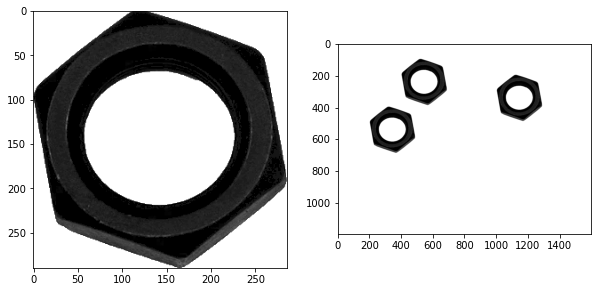

In [2]:
template_im = cv.imread(r'template.png', cv.IMREAD_GRAYSCALE)
belt_im = cv.imread(r'belt.png', cv.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(template_im, cmap='gray')
ax[1].imshow(belt_im, cmap='gray')
plt.show()

# PART I

In [3]:
th_t, img_t = cv.threshold(template_im, 0, 255, cv.THRESH_BINARY_INV +\
                           cv.THRESH_OTSU)
th_b, img_b = cv.threshold(belt_im, 0, 255, cv.THRESH_BINARY_INV +\
                           cv.THRESH_OTSU)

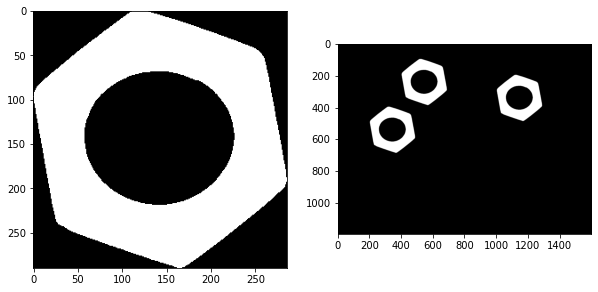

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(img_t, cmap='gray')
ax[1].imshow(img_b, cmap='gray')
plt.show()

In [5]:
kernel = np.ones((3,3), dtype=np.uint8)
closing_t = cv.morphologyEx(img_t, cv.MORPH_CLOSE, kernel)
closing_b = cv.morphologyEx(img_b, cv.MORPH_CLOSE, kernel)

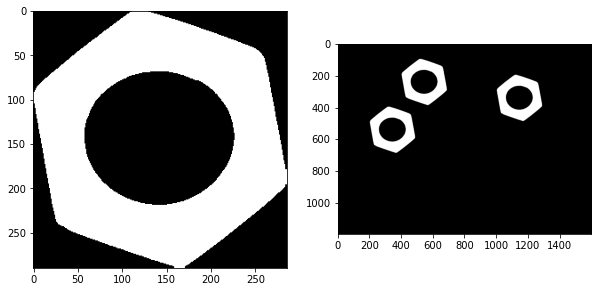

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(closing_t, cmap='gray')
ax[1].imshow(closing_b, cmap='gray')
plt.show()

In [7]:
retval_t, labels_t, stats_t, centroids_t =\
cv.connectedComponentsWithStats(closing_t)
retval_b, labels_b, stats_b, centroids_b =\
cv.connectedComponentsWithStats(closing_b)

In [8]:
print("Number of connected components on template:",\
      np.unique(labels_t).shape[0],\
      "\nNumber of connected components on belt:",\
      np.unique(labels_b).shape[0], end='\n\n')
print("Stats for template:\n", stats_t, "\nStats for belt:\n",\
      stats_b, end='\n\n')
print("Centeroids of template:\n", centroids_t, "\nCentroids of nuts on belt:\n",\
      centroids_b, end='\n\n')

Number of connected components on template: 2 
Number of connected components on belt: 4

Stats for template:
 [[    0     0   286   290 42290]
 [    0     0   286   290 40650]] 
Stats for belt:
 [[      0       0    1600    1200 1798161]
 [    400     100     286     290   40613]
 [   1000     200     286     290   40613]
 [    200     400     286     290   40613]]

Centeroids of template:
 [[142.18770395 145.19172381]
 [142.82489545 143.780369  ]] 
Centroids on belt:
 [[ 807.85728475  614.56805258]
 [ 542.82567158  243.78479797]
 [1142.82567158  343.78479797]
 [ 342.82567158  543.78479797]]



In [9]:
contours_t, hierarchy_t = cv.findContours(closing_t, cv.RETR_EXTERNAL,\
                                          cv.CHAIN_APPROX_SIMPLE)
contours_b, hierarchy_b = cv.findContours(closing_b, cv.RETR_EXTERNAL,\
                                          cv.CHAIN_APPROX_SIMPLE)

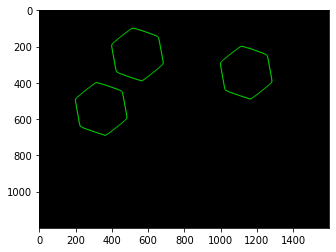

In [10]:
# Visualizing contours
im_contours_belt = np.zeros((belt_im.shape[0],belt_im.shape[1],3), np.uint8)
conts = cv.drawContours(im_contours_belt, contours_b, -1,\
                        (0,255,0), 3).astype('uint8')
plt.imshow(conts)
plt.show()

In [11]:
label = 1 # remember that the label of the background is 0
belt = ((labels_b >= label)*255).astype('uint8')
belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL,\
                                                cv.CHAIN_APPROX_SIMPLE)
for j,c in enumerate(belt_cont):
        print(cv.matchShapes(contours_t[0], c, cv.CONTOURS_MATCH_I1, 0.0))

0.00010071698397173812
0.00010071698397950968
0.00010071698397506879


# PART II

In [12]:
ca = cv.contourArea(contours_b[1])
print(ca)

60059.5


In [13]:
M = cv.moments(contours_b[1])
cx, cy = int(M['m10']/M['m00']), int(M['m01']/M['m00'])
print(cx, cy)

1142 343


In [14]:
count = 1
object_prev_frame = np.array([cx, cy, ca, count])

In [15]:
delta_x = 15

# PART III - GRADING

## get_indexed_image function

In [16]:
def get_indexed_image(im):
  """
    Thresholding, closing, and connected component anysis lumped
  """
  th, img = cv.threshold(im, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
  kernel = np.ones((3,3), dtype=np.uint8)
  closing = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)
  retval, labels, stats, centroids = cv.connectedComponentsWithStats(closing)
  return retval, labels, stats, centroids

## is_new function

In [17]:
def is_new(a, b, delta, i):
  """
    Vector Dissimilarity with an Array of Vectors
    Checks if vector b is similar to a one or more vectors in a outside the tolerances specified in delta.
    vector i specified which elements in b to compare with those in a
  """
  if (np.absolute(a[:,i] - b[i]) > delta).all(): return True
  return False

In [18]:
# check is_new  expected answer False

a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
 [7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
 [1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])

assert is_new(a, b, delta, i) == False, " Check the function "

## prev_index function

In [19]:
def prev_index(a, b, delta, i):
  """
    Returns Previous Index
    Returns the index of the appearance of the object in the previous frame
  """
  index = np.where(np.absolute(a[:,i] - b[i]) <= delta)
  return index[0]

In [20]:
# check prev_index  expected answer 1
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
 [7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
 [1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])

assert prev_index(a,b,delta,i) == 1, " Check the function "

Using above functions to detect objects in videos

# Detect hexagonal nuts in conveyor_two_frame.mp4

In [21]:
col_frames = []
frames = []
cap = cv.VideoCapture('conveyor_two_frame.mp4') # give the correct path here
while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    col_frames.append(frame)
    frames.append(cv.cvtColor(frame, cv.COLOR_BGR2GRAY))
cap.release()
cv.destroyAllWindows()
frames = np.array(frames)
print("Frames shape:", frames.shape)

Can't receive frame (stream end?). Exiting ...
Frames shape: (2, 1080, 1920)


## Drawing contours in each frame

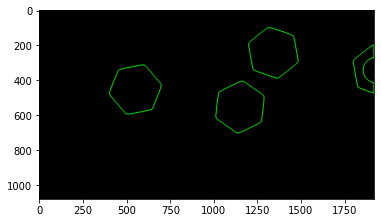

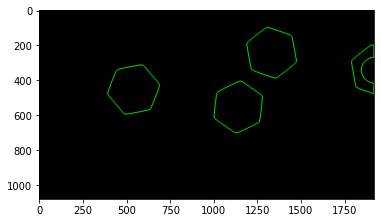

In [22]:
for grey in frames:
  retval, labels, stats, centroids = get_indexed_image(grey)
  contours, hierarchy = cv.findContours(((labels >= 1)*255).astype('uint8'),\
                                    cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  im_contours_belt = np.zeros((grey.shape[0],grey.shape[1],3), np.uint8)
  conts = cv.drawContours(im_contours_belt, contours, -1,\
                          (0,255,0), 3).astype('uint8')
  plt.imshow(conts)
  plt.show()

## Segmentation
Going through the video frame-by-frame, generating the object flow of each frame by detecting contours, comparing their shapes with template, and saving the hexagonal objects in each frame.

In [23]:
object_flow = []
matching_threshold = 4.5e-3
for grey in frames:
  retval, labels, stats, centroids = get_indexed_image(grey)
  contours, hierarchy = cv.findContours(((labels >= 1)*255).astype('uint8'),\
                                    cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  frame_objects = []
  for i in range(len(contours)):
    if cv.matchShapes(contours_t[0], contours[i], cv.CONTOURS_MATCH_I1, 0.0) >\
                                                matching_threshold: continue
    ca = int(cv.contourArea(contours[i]))
    M = cv.moments(contours[i])
    cx, cy = int(M['m10']/M['m00']), int(M['m01']/M['m00'])
    frame_objects.append([cx, cy, ca, i+1])
  frame_objects = np.array(frame_objects)
  object_flow.append(frame_objects)

## Counting
Checking for new objects and counting the number of unique nuts.
However, this is not effective for this short video as it has no rotation of objects.

In [24]:
prev_frame = object_flow[0]
obj_count = object_flow[0].shape[0]
for frame in object_flow[1:]:
  for obj in frame:
    if is_new(prev_frame, obj, 15, 0):
      obj_count+=1
  prev_frame = frame
print("Detected", obj_count, "nuts in the video")

Detected 3 nuts in the video


## Tracking
By going through the object flow frame-by-frame; identifying new objects in each frame, giving identification numbers to new objects and assigning the same identification number to objects coming from previous frame.

In [25]:
prev_frame = object_flow[0]
obj_count = object_flow[0].shape[0]
for frame in object_flow[1:]:
  for obj in frame:
    if is_new(prev_frame, obj, delta_x, 0):
      obj_count+=1
      obj[3] = obj_count
    else:
      obj[3] = prev_frame[prev_index(prev_frame, obj, delta_x, 0)][0, 3]
  prev_frame = frame

## Adding text
Embed the identification number of each object in each frame. Here, the original color image is used.

In [26]:
for i in range(len(frames)):
  frame = col_frames[i]
  for obj in object_flow[i]:
    frame = cv.putText(frame, str(int(obj[3])), (int(obj[0]), int(obj[1])),\
                       cv.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2)

## Encoding
Using MP4V encoder

In [27]:
# Encoding the frames
file_name = 'test1.mp4'
fourcc = cv.VideoWriter_fourcc(*'MP4V')
out = cv.VideoWriter(file_name, fourcc, 30.0, (1920,  1080), True)
for frame in col_frames:
    out.write(frame)

# Release everything if job is finished
out.release()

# Detect hexagonal nuts in conveyor_with_rotation.mp4

In [28]:
col_frames = []
frames = []
cap = cv.VideoCapture('conveyor_with_rotation.mp4') # give the correct path here
while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    col_frames.append(frame)
    frames.append(cv.cvtColor(frame, cv.COLOR_BGR2GRAY))
cap.release()
cv.destroyAllWindows()
frames = np.array(frames)
print("Frames shape:", frames.shape)

Can't receive frame (stream end?). Exiting ...
Frames shape: (280, 1080, 1920)


## Drawing contours in each frame

In [ ]:
for grey in frames:
  retval, labels, stats, centroids = get_indexed_image(grey)
  contours, hierarchy = cv.findContours(((labels >= 1)*255).astype('uint8'),\
                                    cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  im_contours_belt = np.zeros((grey.shape[0],grey.shape[1],3), np.uint8)
  conts = cv.drawContours(im_contours_belt, contours, -1,\
                          (0,255,0), 3).astype('uint8')
  plt.imshow(conts)
  plt.show()
  print()

Doing it for only 5 frames for visualization as 280 images makes the report too long.

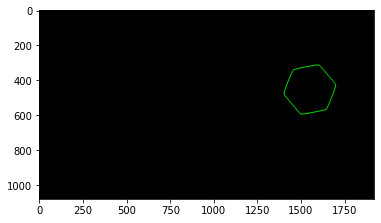

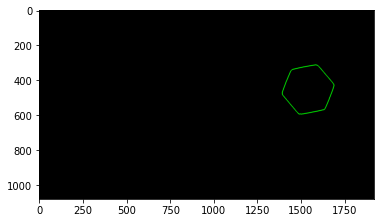

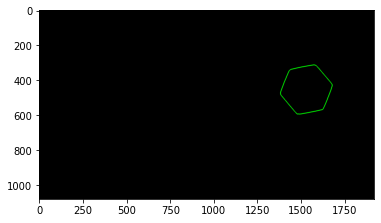

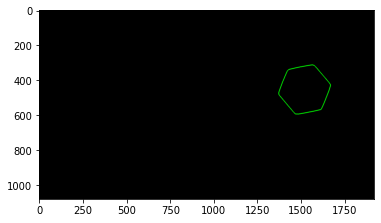

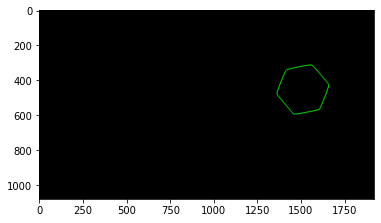

In [30]:
for grey in frames[:5]:
  retval, labels, stats, centroids = get_indexed_image(grey)
  contours, hierarchy = cv.findContours(((labels >= 1)*255).astype('uint8'),
                                    cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  im_contours_belt = np.zeros((grey.shape[0],grey.shape[1],3), np.uint8)
  conts = cv.drawContours(im_contours_belt, contours, -1,\
                          (0,255,0), 3).astype('uint8')
  plt.imshow(conts)
  plt.show()
  print()

## Segmentation
Adding the contour_store to keep the bounding hexagons of each nut to be put in video.

In [31]:
object_flow = []
contour_store = []
matching_threshold = 4.5e-3
for grey in frames:
  retval, labels, stats, centroids = get_indexed_image(grey)
  contours, hierarchy = cv.findContours(((labels >= 1)*255).astype('uint8'),\
                                    cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  frame_objects = []
  conts = []
  for i in range(len(contours)):
    if cv.matchShapes(contours_t[0], contours[i], cv.CONTOURS_MATCH_I1, 0.0) >\
                                                matching_threshold: continue
    ca = int(cv.contourArea(contours[i]))
    M = cv.moments(contours[i])
    cx, cy = int(M['m10']/M['m00']), int(M['m01']/M['m00'])
    frame_objects.append([cx, cy, ca, i+1])
    conts.append(contours[i])
  frame_objects = np.array(frame_objects)
  contour_store.append(conts)
  object_flow.append(frame_objects)

## Tracking

In [32]:
prev_frame = object_flow[0]
obj_count = object_flow[0].shape[0]
for frame in object_flow[1:]:
  for obj in frame:
    if is_new(prev_frame, obj, delta_x, 0):
      obj_count+=1
      obj[3] = obj_count
    else:
      obj[3] = prev_frame[prev_index(prev_frame, obj, delta_x, 0)][0, 3]
  prev_frame = frame

## Adding text
In addition to putting the text label, a bounding hexagon for each nut and my index number are added to each frame.

In [33]:
for i in range(len(frames)):
  frame = col_frames[i]
  for obj in object_flow[i]:
    frame = cv.putText(frame, str(int(obj[3])), (int(obj[0]), int(obj[1])),\
                       cv.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2)
    frame = cv.putText(frame, '180616T', (20, 1060),\
                       cv.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2)
  frame = cv.drawContours(frame, contour_store[i], -1,\
                          (0, 0, 255), 3).astype(np.uint8)

# Complete run for conveyor_with_rotation.mp4

In [34]:
import cv2 as cv
import numpy as np

print("Identification of objects in a video\nby 180616T-P.M.P.H. Somarathne")

def get_indexed_image(im):
  """
    Thresholding, closing, and connected component anysis lumped
  """
  th, img = cv.threshold(im, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
  kernel = np.ones((3,3), dtype=np.uint8)
  closing = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)
  retval, labels, stats, centroids = cv.connectedComponentsWithStats(closing)
  return retval, labels, stats, centroids

def is_new(a, b, delta, i):
  """
    Vector Dissimilarity with an Array of Vectors
    Checks if vector b is similar to a one or more vectors in a outside the
        tolerances specified in delta.
    vector i specified which elements in b to compare with those in a
  """
  if (np.absolute(a[:,i] - b[i]) > delta).all(): return True
  return False

def prev_index(a, b, delta, i):
  """
    Returns Previous Index
    Returns the index of the appearance of the object in the previous frame
  """
  index = np.where(np.absolute(a[:,i] - b[i]) <= delta)
  return index[0]

# Detect contours of template.png to be used as reference
print("Reading template")
template_im = cv.imread(r'template.png', cv.IMREAD_GRAYSCALE)
th_t, img_t = cv.threshold(template_im, 0, 255, cv.THRESH_BINARY_INV +\
                           cv.THRESH_OTSU)
kernel = np.ones((3,3), dtype=np.uint8)
closing_t = cv.morphologyEx(img_t, cv.MORPH_CLOSE, kernel)
contours_t, hierarchy_t = cv.findContours(closing_t, cv.RETR_EXTERNAL,\
                                          cv.CHAIN_APPROX_SIMPLE)

# Read the video
print("Reading video")
col_frames = []
frames = []
cap = cv.VideoCapture('conveyor_with_rotation.mp4') # give the correct path here
while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    col_frames.append(frame)
    frames.append(cv.cvtColor(frame, cv.COLOR_BGR2GRAY))
cap.release()
cv.destroyAllWindows()
frames = np.array(frames)
print("Frames shape:", frames.shape)

# Generate object flow
print("Generating object flow")
object_flow = []
contour_store = []
matching_threshold = 4.5e-3
for grey in frames:
  retval, labels, stats, centroids = get_indexed_image(grey)
  contours, hierarchy = cv.findContours(((labels >= 1)*255).astype('uint8'),\
                                    cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  frame_objects = []
  conts = []
  for i in range(len(contours)):
    if cv.matchShapes(contours_t[0], contours[i], cv.CONTOURS_MATCH_I1, 0.0)>\
                                                matching_threshold: continue
    ca = int(cv.contourArea(contours[i]))
    M = cv.moments(contours[i])
    cx, cy = int(M['m10']/M['m00']), int(M['m01']/M['m00'])
    frame_objects.append([cx, cy, ca, i+1])
    conts.append(contours[i])
  frame_objects = np.array(frame_objects)
  contour_store.append(conts)
  object_flow.append(frame_objects)

# Track the nut and assign identification number
print("Tracking the nuts")
delta_x = 15
prev_frame = object_flow[0]
obj_count = object_flow[0].shape[0]
for frame in object_flow[1:]:
  for obj in frame:
    if is_new(prev_frame, obj, 15, 0):
      obj_count+=1
      obj[3] = obj_count
    else:
      obj[3] = prev_frame[prev_index(prev_frame, obj, delta_x, 0)][0, 3]
  prev_frame = frame
print("Detected", obj_count, "nuts in the video")

# Add identification number into original image as text
print("Adding text")
for i in range(len(frames)):
  frame = col_frames[i]
  for obj in object_flow[i]:
    frame = cv.putText(frame, str(int(obj[3])), (int(obj[0]), int(obj[1])),\
                       cv.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2)
    frame = cv.putText(frame, '180616T', (20, 1060),\
                       cv.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2)
  frame = cv.drawContours(frame, contour_store[i], -1,\
                          (0, 255, 0), 5).astype(np.uint8)

# Encoding the frames
print("Encoding")
file_name = '180616t_en2550_a05.mp4'
fourcc = cv.VideoWriter_fourcc(*'MP4V')
out = cv.VideoWriter(file_name, fourcc, 30.0, (1920,  1080), True)
for frame in col_frames:
    out.write(frame)

# Release everything if job is finished
out.release()
print("Identification complete. You can view", file_name)

Identification of objects in a video
by 180616T-P.M.P.H. Somarathne
Reading template
Reading video
Can't receive frame (stream end?). Exiting ...
Frames shape: (280, 1080, 1920)
Generating object flow
Tracking the nuts
Detected 5 nuts in the video
Adding text
Encoding
Identification complete. You can view 180616t_en2550_a05.mp4
